# 1. Import packages and load data

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
} //disable auto-scrolling for long outputs

<IPython.core.display.Javascript object>

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint as pp

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve


# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat(objs=[train, test], axis=0, ignore_index=True) # full data set will be useful to tranform variables in same
                                                                   # way and looking at trends

# 2. Exploratory data analysis

## 2.1 Dataset information

We are dealing with data from the passengers aboard the Titanic. The aim is to build a model based on train data to predict the survival of the passenger in the test set.

In [3]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


This a sizeable amount of data points close to the total amount of passengers aboard (1317). Let's look at the variables involved:

In [4]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

The following variables are provided, these might be selected/combined as features of our model later on:
* PassengerId is the unique identifier for each passenger/row.
* Survived is our target variable, 1 if the passenger survived.
* Pclass is the passenger class representing socio-economic status (highest 1st class-1, middle 2nd class-2, low 3rd class-3).
* Name is the full name with title.
* Sex can be 'female' or 'male'.
* Age is the numeric age.
* SibSp is the number of siblings and/or spouses onboard.
* Parch is the number of parents and/or children onboard.
* Ticket is the ticket identifier, prefix and number.
* Fare is the cost of the ticket.
* Cabin is the cabin of the passenger.
* Embarked is the port in which passenger embarked with 3 unique values ('S'-Southampton, 'C'-Cherbourg, 'Q'-Queenstown).

Ignoring PassengerId, which is not useful to explain survival, we have:
* 2 numerical continuous variables: Age and Fare.
* 2 numerical discrete variables: Sibsp and Parch.
* 4 categorical variables: Survived, Name, Sex, Ticket, Cabin and Embarked.
* 1 ordinal categorical variable: Pclass (1 being highest).

Of these, the following have missing values:
* Age: 177 in train and 86 in test.
* Fare: 1 in test.
* Cabin: 687 in train and 327 in test.
* Embarked: 2 in train.

## 2.2 Univariate analysis
We now look at how each variable is distributed individually.
### 2.2.1 Numerical variables

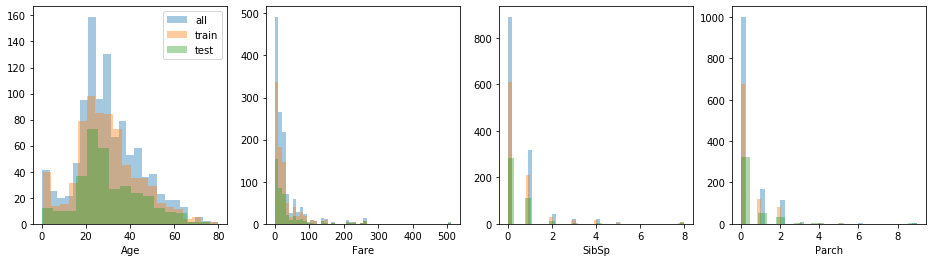

In [5]:
labels = ['all', 'train', 'test']
to_plot = ['Age', 'Fare', 'SibSp', 'Parch']
plt.figure(figsize=(16, 4))
plt_id = 141

for ii in range(len(to_plot)):
    plt.subplot(plt_id)
    sns.distplot(data[to_plot[ii]], kde=False, label='all')
    sns.distplot(train[to_plot[ii]], kde=False, label='train')
    sns.distplot(test[to_plot[ii]], kde=False, label='test')

    if ii == 0:
        plt.legend()

    plt_id += 1

plt.show()

We can observe that:
* Age shows a bimodal distribution skewed to the left, but the range of values seems to represent well its variation. The test set as it does not have the peak between 0-5yrs.
* Fare shows a heavily skewed unimodal distribution, with really big outliers in all data sets. It might be worth transforming the range of values.
* SibSp and Parch are sparse and mainly have values between 0 and 2, so we may want to group categories to avoid sparsity.

### 2.2.2 Categorical variables

In [6]:
data.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

Name, Ticket and Cabin are mostly unique or missing values, so they are not useful features as such. We would need to investigate them further to see if we can derive new features from them.

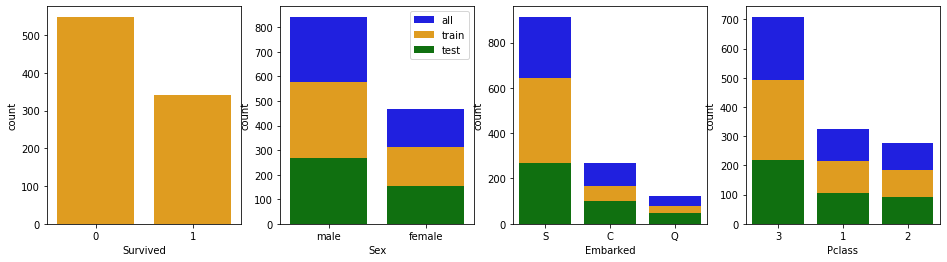

In [7]:
to_plot = ['Survived', 'Sex', 'Embarked', 'Pclass']
plt.figure(figsize=(16, 4))
plt_id = 141

for ii in range(len(to_plot)):
    plt.subplot(plt_id)
    to_plot_ii = to_plot[ii]

    if to_plot_ii == 'Survived': # Survived only in train set
        sns.countplot(train[to_plot_ii], label='train', color='orange', order=train[to_plot_ii].value_counts().index)
    else:
        sns.countplot(data[to_plot_ii], label='all', color='blue', order=data[to_plot_ii].value_counts().index)
        sns.countplot(train[to_plot_ii], label='train', color='orange', order=train[to_plot_ii].value_counts().index)
        sns.countplot(test[to_plot_ii], label='test', color='green', order=test[to_plot_ii].value_counts().index)

    if ii==1:
        plt.legend()

    plt_id += 1

plt.show()

* Test set distributions are more equally distributed but in general are similar to the train set, meaning that these features will generalise well.
* Most passengers in train data died, in line with official figures of 68% survival rate.
* We have more male than female in all data sets.
* Most passengers embarked in Southampton and were 3rd class.

## 2.2 Bivariate analysis

### 2.2.1 General correlations

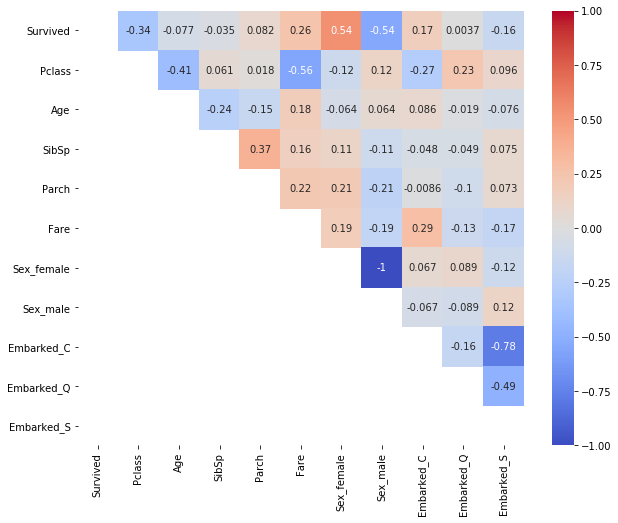

In [8]:
dummies = pd.get_dummies(data, columns=['Sex', 'Embarked']) # convert strings to indicators (only numerics for correlation)
dummies = dummies.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1) # ignore variables not useful without transformations

corr = dummies.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            mask=np.tri(corr.shape[0], k=0))
plt.show()

* Many variables are correlated (>0.1) between each other, so we may think of combining them.
* Survived has a strong correlation with Sex (female likelier to survive), Embarked (Cherbourg likelier to survive, Queensland less), Pclass (higher class likelier to survive) and Fare (higher fare likelier to survive). So, these are all interesting variables to consider, many strongly correlated, as seen below.
* Other strong correlations worth noting are:
    * Pclass with Age (higher class older people), Fare (higher fare likelier to be higher class) and Embarked (higher class in Cherbourg, lower in Queensland).
    * Age with SibSp and Parch (older tend to have more familiars on board).
    * SibSp and Parch are correlated between each other and both represent family on board. Both are correlated with Fare (more familiars result in more expensive tickets) and Sex (females tend to have more familiars on board).
    * Fare with Sex (higher for female, as they travelled in larger groups) and Embarked (higher in Cherbourg, lower in Queensland, as seen with class).

### 2.2.2 Detailed correlation to target variable

#### 2.2.2.1 Class

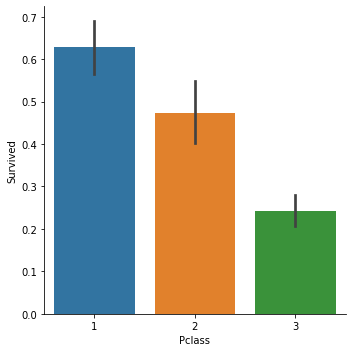

In [9]:
sns.catplot(x='Pclass', y='Survived', kind='bar', data=train)

Passengers in higher class likelier to survive.

#### 2.2.2.2 Sex

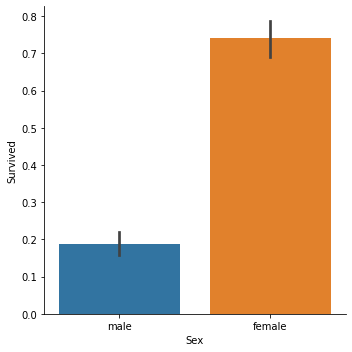

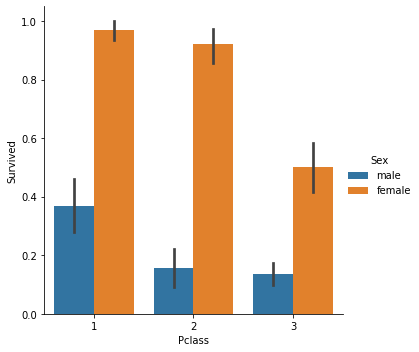

In [10]:
sns.catplot(x='Sex', y='Survived', kind='bar', data=train)
sns.catplot(x='Pclass', y='Survived', hue='Sex', kind='bar', data=train)

Female likelier to survive, showing almost an equal survival rate between 1st and 2nd class.

#### 2.2.2.3 Age

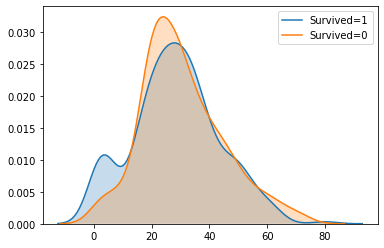

In [11]:
sns.kdeplot(train.Age[train.Survived == 1], shade=True, label='Survived=1')
sns.kdeplot(train.Age[train.Survived==0], shade=True, label='Survived=0')

Children were likelier to survive. However, as seen previously, our test set doesn't contain a large amount of points there, so this characteristic of the train data won't be that useful to predict survival in the test set.

#### 2.2.2.4 SibSp and Parch

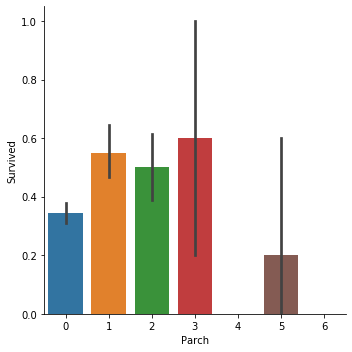

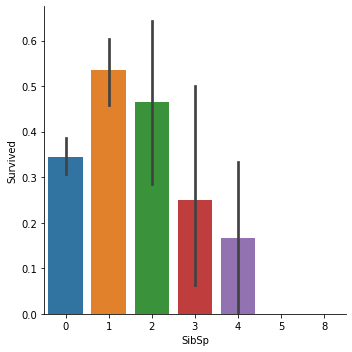

In [12]:
sns.catplot(x='Parch', y='Survived', kind='bar', data=train)
sns.catplot(x='SibSp', y='Survived', kind='bar', data=train)

People with 1-3 familiars on board seemed likelier to survive than those with none. Those with more than 2 show a really strong variability (likely due to the little amount of samples). This again points to the need of removing sparse categories.

#### 2.2.2.5 Fare

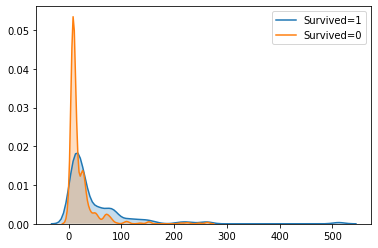

In [13]:
sns.kdeplot(train.Fare[train.Survived == 1], shade=True, label='Survived=1')
sns.kdeplot(train.Fare[train.Survived==0], shade=True, label='Survived=0')

No clear trend noticeable, since the variable is heavily skewed. Again, scaling this variable might be worth.

#### 2.2.2.6 Embarked

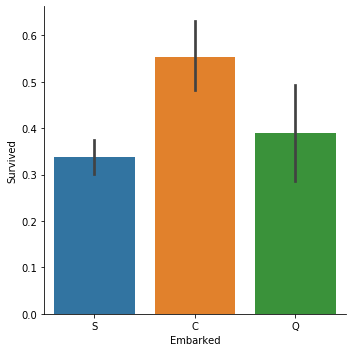

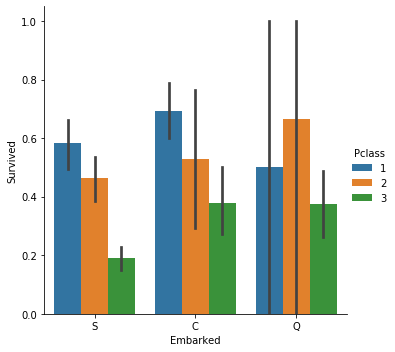

In [14]:
sns.catplot(x='Embarked', y='Survived', kind='bar', data=train)
sns.catplot(x='Embarked', y='Survived', hue='Pclass', kind='bar', data=train)

Passengers embarked in Cherbourg likelier to survive, but this was also the place were most 1st class embarked. However, Queensland seemed to show a relatively high survival rate, even though most passengers were 3rd class, so this variable adds information beyond class.

# 3. Data cleaning

In this section, we fix our data by analysing outliers and treating missing values.

## 3.1 Outliers

We use IsolationForest method to investigate the 1% outlier values in our data set and see if we should ignore them.

In [15]:
X = data[['Age','Fare','SibSp','Parch']]
X = X.fillna({'Age': X.Age.mean(), 'Fare': X.Fare.mean()}) # fill with average values, not outliers

iso_forest = IsolationForest(contamination=0.01,
                             random_state=123456).fit(X)
id_outliers = iso_forest.predict(X)
outliers = data[id_outliers==-1]
outliers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0.0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S
180,181,0.0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S
201,202,0.0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,NaN,S
324,325,0.0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,NaN,S
438,439,0.0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S
792,793,0.0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,S
846,847,0.0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.5500,NaN,S
863,864,0.0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
915,916,NaN,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.3750,B57 B59 B63 B66,C
960,961,NaN,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60.0,1,4,19950,263.0000,C23 C25 C27,S


The algorithm returns passengers with large SibSp (all from the Sage family with 11 members onboard) or passengers with high fares, which were fewer.

We notice that these kinds of passengers were both in the train and in the test set (observations > 891), so we decide to keep them and handle them later (via tranformations, models less sensitive to them)

## 3.2 Missing data

We have missing data in Age, Fare, Cabin and Embarked variables. We decide to fill these instead of using indicators to signal "missingness".

### 3.2.1 Age

Age has ~20% missing values, so we decide to predict its values based on other variables.

Looking at the correlations in 2.2.1 Age has higher correlation with Pclass, Fare, SibSp and Parch. We fit a linear regression model to predict missing ages based on these.

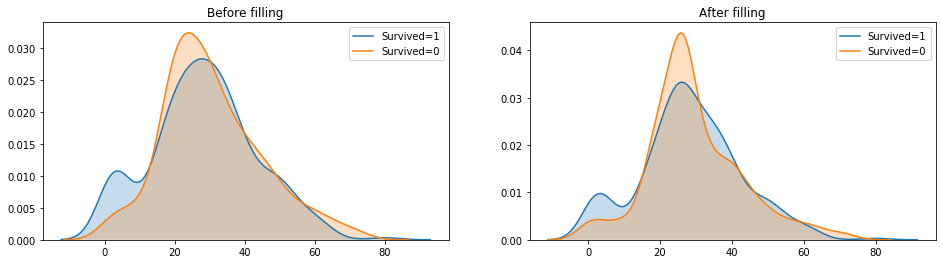

In [16]:
age_data = data[['Age', 'Pclass', 'Fare', 'SibSp', 'Parch']]
age_data = age_data[age_data['Fare'].notna()]

X_age_train = age_data[age_data['Age'].notnull()].drop(columns='Age') # train set are samples with age not null
y_age_train = age_data[age_data['Age'].notnull()]['Age']
X_age_test = age_data[age_data['Age'].isnull()].drop(columns='Age')

lreg = LinearRegression(normalize=True) # fit linear regression
lreg.fit(X_age_train, y_age_train)
predict_age = lreg.predict(X_age_test)

data.loc[data.Age.isnull(), 'Age'] = predict_age # fill missing

plt.figure(figsize=(16,4)) # plot to see how distribution has changed after filling
plt.subplot(121)
sns.kdeplot(train.Age[train.Survived == 1], shade=True, label='Survived=1')
sns.kdeplot(train.Age[train.Survived==0], shade=True, label='Survived=0')
plt.title('Before filling')
plt.subplot(122)
sns.kdeplot(data.Age[data.Survived == 1], shade=True, label='Survived=1')
sns.kdeplot(data.Age[data.Survived==0], shade=True, label='Survived=0')
plt.title('After filling')
plt.legend()

We can see a similar dependency of our target on age, only the chance of surviving for the 20-30 yr olds is reduced.

### 3.2.2 Fare

There is only a missing value for Fare:

In [17]:
data[data.Fare.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Fare is highly correlated with Pclass, Embarked, SibSp and Parch. So we use the median (fare is highly skewed) fare of these passengers:

In [18]:
med_Fare = data.groupby(['Pclass', 'Embarked', 'Parch', 'SibSp']).Fare.median()[3]['S'][0][0]
data.loc[data.Fare.isnull(), 'Fare'] = med_Fare

### 3.2.3 Cabin

This variable is mostly missing values and not useful without tranformation, so we cannot infer any useful correlation to fill it. We set nulls to 'missing' for now:

In [19]:
data.loc[data.Cabin.isnull(), 'Cabin'] = 'missing'

### 3.2.4 Embarked

There are 2 missing values in the train set:

In [20]:
data[data.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Both passengers share ticket, so they embarked from the same port. Embarked is mostly correlated with Pclass and Fare, which in turn depend on each other. So, we use the most common value for 1st class:

In [21]:
most_common_Embarked =  data.groupby('Pclass').apply(lambda x: x.Embarked.value_counts().index[0])
data.loc[data.Embarked.isnull(), 'Embarked'] = most_common_Embarked[1]

### 3.2.5 Quick check

No missing values in our data (apart from the target variable in the test set):

In [22]:
data.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64

# 4. Feature engineering

Here, we use our insights from EDA and cleaned data to create and select a set of features to fit our model on.

### 4.1 New features

### 4.1.1 Title

The name variable starts with the title of the passenger, which is a way to distinguish their status, so that might show some correlation with survival.

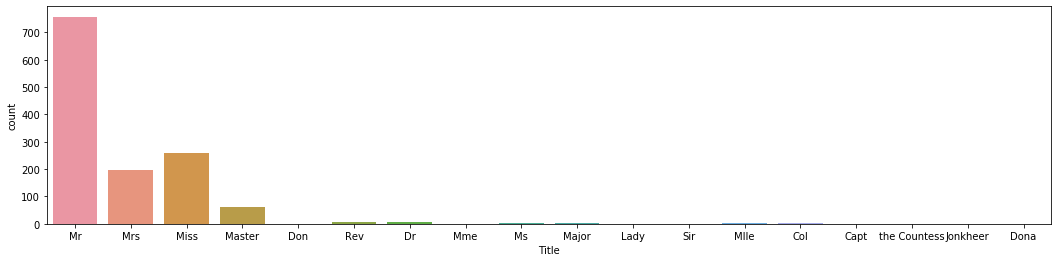

In [23]:
data['Title'] = data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
plt.figure(figsize=(18,4))
sns.countplot(data.Title)

Title feature is sparse, so we group together similar categories:

<Figure size 1296x288 with 0 Axes>

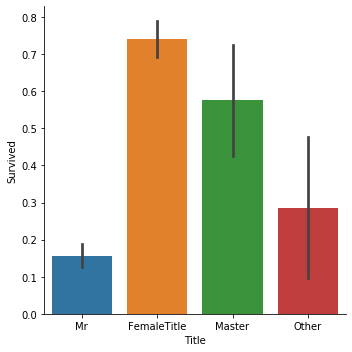

In [24]:
data['Title'] = data['Title'].replace(['Mrs', 'Miss', 'Mme', 'Mlle',  'Ms', 'Lady', 'Dona', 'the Countess'], 'FemaleTitle')
data['Title'] = data['Title'].replace(['Don', 'Dr', 'Major', 'Sir', 'Capt', 'Jonkheer', 'Col' ,'Rev'], 'Other')
data = data.drop('Name', axis=1)
plt.figure(figsize=(18,4))
sns.catplot(x='Title', y='Survived', kind='bar', data=data)

So, passengers with female titles had higher chances of survival (as expected from Sex), but also Master seemed to have higher survival chances within males. So, this feature adds information beyond the Sex distinction.

### 4.1.2 Deck

Cabin is highly sparse so using only the first letter, which represents the deck, might bring a more useful feature.

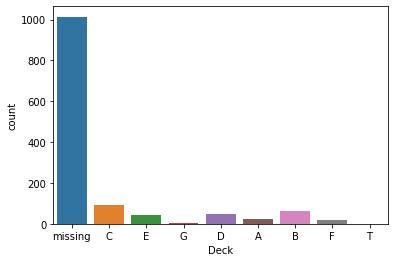

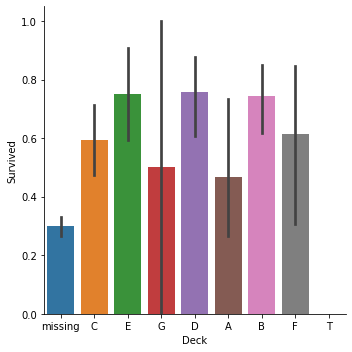

In [25]:
data['Deck'] = pd.Series(x[0] if not x=='missing' else 'missing' for x in data['Cabin'])
sns.countplot(data.Deck)
sns.catplot(x='Deck', y='Survived', kind='bar', data=data)

This feature is sparse and the clearest trend is that those without deck had lower survival rate. We decide to create two groups only: missing or available

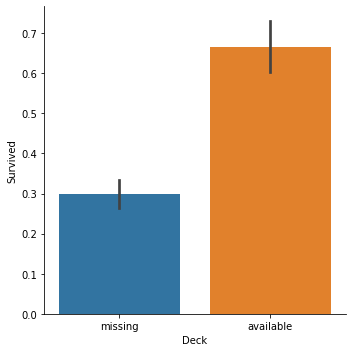

In [26]:
data.loc[data.Deck!='missing', 'Deck'] = 'available'
data = data.drop('Cabin', axis=1)
sns.catplot(x='Deck', y='Survived', kind='bar', data=data)

### 4.1.3 Ticket

Ticket is heavily sparse, but has some repeated values meaning that some passengers travelled under the same ticket. This could influence survival rate, so we compute the ticket counts:

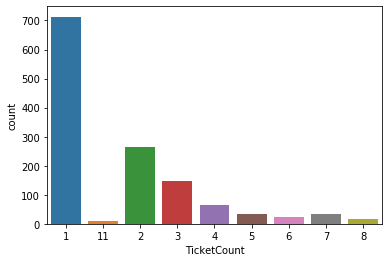

In [27]:
data['TicketCount'] = data.groupby('Ticket')['Ticket'].transform('count')
data['TicketCount'] = data.TicketCount.astype(str)
sns.countplot(data.TicketCount)

Most people travelled in an individual ticket or shared with 2 or 3, so we group all with more than 3 ticket counts together to reduce sparsity:

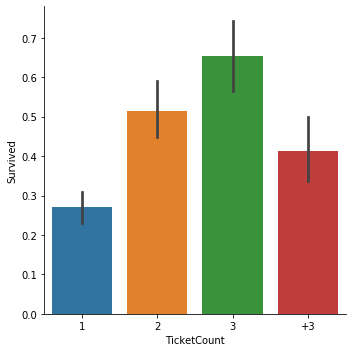

In [28]:
data.loc[~data.TicketCount.isin(['1', '2', '3']),['TicketCount']] = '+3'
data = data.drop('Ticket', axis=1)
sns.catplot(x='TicketCount', y='Survived', kind='bar', data=data, order=['1','2','3','+3'])

So, those travelling sith a shared ticket between 2 or 3 people had higher survival chances.

### 4.1.4 Log(fare)

Fare shows a strong positive skew, so we can reduce this by using a logtranformation:

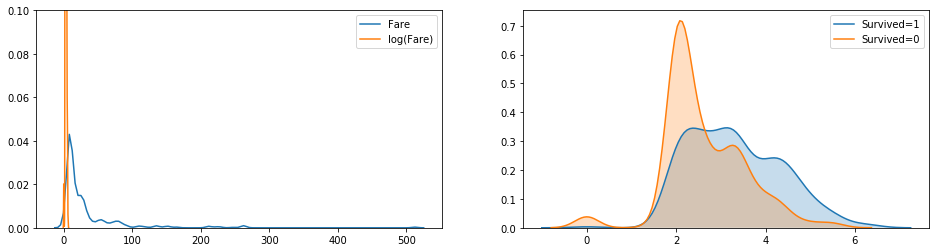

In [29]:
data['Fare_log'] = data['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

plt.figure(figsize=(16,4))

plt.subplot(121)
sns.kdeplot(data.Fare, label='Fare')
sns.kdeplot(data.Fare_log, label='log(Fare)')
plt.ylim([0, 0.1])
plt.subplot(122)
sns.kdeplot(data.Fare_log[data.Survived == 1], shade=True, label='Survived=1')
sns.kdeplot(data.Fare_log[data.Survived==0], shade=True, label='Survived=0')

data= data.drop('Fare', axis=1)
plt.show()

Skewness is clearly reduced and we can it is clearer that passengers with higher fares had higher chances to survive, so we drop fare.

### 4.1.5 Family size

We saw that SibSp and Parch are related and both are sparse, so joining them together in a feature that explains the number of familiars sounds sensible:

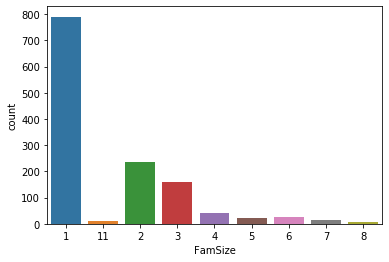

In [30]:
data['FamSize'] = data.SibSp + data.Parch + 1
data['FamSize'] = data.FamSize.astype(str)
sns.countplot(data.FamSize)

We still have very few values above 4 so we join those into a new category '+3':

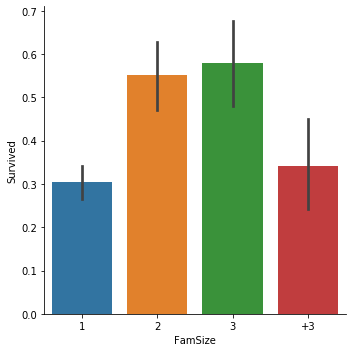

In [31]:
data.loc[~data.FamSize.isin(['1', '2', '3']),['FamSize']] = '+3'
data[data.FamSize=='+3']
data = data.drop(['Parch', 'SibSp', 'PassengerId'], axis=1) # we also drop PassengerId
sns.catplot(x='FamSize', y='Survived', kind='bar', data=data, order=['1','2','3','+3'])

So, medium size families had the best chance for survival, which is similar to what we saw when looking at Parch and SibSp separately.

## 4.2 Final transformations

Our continuous numeric variables (Age and Fare_log) are normalized:

In [32]:
cols_to_scale = ['Age', 'Fare_log']
scaler = preprocessing.StandardScaler().fit(data[cols_to_scale])
data[cols_to_scale] = scaler.transform(data[cols_to_scale])
data.head()

,Survived,Pclass,Sex,Age,Embarked,Title,Deck,TicketCount,Fare_log,FamSize
0,0.0,3,male,-0.548549,S,Mr,missing,1,-0.925472,2
1,1.0,1,female,0.648846,C,FemaleTitle,available,2,1.351645,2
2,1.0,3,female,-0.249200,S,FemaleTitle,missing,1,-0.836784,1
3,1.0,1,female,0.424334,S,FemaleTitle,available,2,1.058261,2
4,0.0,3,male,0.424334,S,Mr,missing,1,-0.821192,1


Our categoricals are converted to indicators via one-hot encoding to be able to add them to the model:

In [33]:
data = pd.get_dummies(data, columns=['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'TicketCount', 'FamSize'])

Finally, we split our data set back into training and test set to feed into our model (X= features, y= target):

In [34]:
train_post = data[:891] # create new variables to keep originals
test_post = data[891:]
X_train = train_post.drop('Survived', axis=1)
y_train = train_post.Survived
X_test = test_post.drop('Survived', axis=1)

# 5. Algorithm

We have a classification problem with potentially non-linear decision boundaries and numeric features contain some extreme values. A random forest looks like a sensible algorithm choice in this case.

## 5.1. Hyperparameter tuning
We create a wide grid of the most relevant hyperparameters and use randomized search stratified k-fold cross validation to find the order of magnitudes for each of them:

In [35]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)] # num. of trees
max_features = ['auto', 'sqrt'] # num. of features for every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # max. levels in the tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # min. samples to split a node
min_samples_leaf = [1, 2, 4] # min. samples to be a leaf node
bootstrap = [True, False] # sample selection for each tree

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 64, 118, 173, 227, 282, 336, 391, 445, 500]}


In [36]:
rf = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123456)
rnd_search = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid,
                               cv=kfold,
                               n_iter=100,
                               random_state=123456,
                               n_jobs=-1)
rnd_search.fit(X_train, y_train)
pp(rnd_search.best_params_)

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 64}


Based on the best random parameters, we refine them by looking at narrower ranges around these with grid search cross validation:

In [37]:
rf_rnd = RandomForestClassifier(**rnd_search.best_params_) # create a random forest with the previous best parameters
grid_params= {'n_estimators': [int(x) for x in np.linspace(100, 500, num = 11)],
              'max_depth' : [int(x) for x in np.linspace(50, 110, num = 11)]} # grid of params to refine

grid_search = GridSearchCV(estimator=rf_rnd,
                       param_grid=grid_params,
                       cv=kfold,
                       n_jobs=-1)
grid_search.fit(X_train, y_train)

rf_final = grid_search.best_estimator_
pp(grid_search.best_params_)

{'max_depth': 98, 'n_estimators': 300}


## 5.2 Learning curves

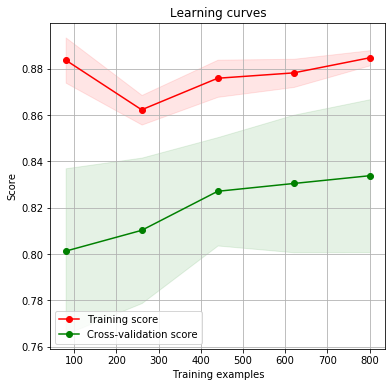

In [38]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5)): # simplified from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return plt

plot_learning_curve(rf_final, 'Learning curves', X_train, y_train, kfold, -1)
plt.show()

CV and training curves started to converge, but there is still a gap between them and training curve seemed to plateau (even increase). So, our model is suffering from high variance rather than high bias and would benefit from more data or simplifications.

## 5.3 Feature importance

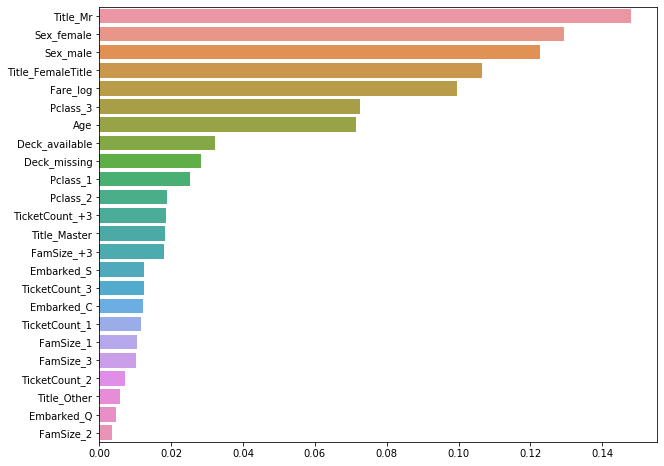

In [39]:
feat_importances = pd.Series(rf_final.feature_importances_, index=X_train.columns, ).sort_values(ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(x=feat_importances.values, y=feat_importances.index)

## 5.4 Predictions and submission

In [40]:
y_pred = rf_final.predict(X_test)
output = pd.DataFrame({'PassengerId': test.PassengerId, 
                       'Survived':y_pred})
output.to_csv('RandomForest_Final.csv', index=False)